In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Forgetters
from Forgetters.GradientBoostingForgetters import GBClassifierForgetter, GBRegressorForgetter
from Forgetters.AdaptiveBoostingForgetters import ABClassifierForgetter, ABRegressorForgetter

# Compression strategies
from CompressionStrategies.DropUnforgettable import DropUnforgettableClassification
from CompressionStrategies.DropNForgets import DropNForgetsClassification

# sklearn stuff
from sklearn.metrics import accuracy_score, classification_report

# Other utils
from utils import predictions_to_y, get_accuracy_score
from DatasetLoader import DatasetLoader

from display_utils import display_pca_and_labels, display_only_kept_points

In [20]:
import openml
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


# List datasets with specific criteria (e.g., classification with >2 classes)
datasets = openml.datasets.list_datasets(tag='OpenML100')
filtered_datasets = [
    ds for ds in datasets.values()
    if ds['NumberOfClasses'] == 2 and ds['NumberOfInstances'] < 1000 and  ds['NumberOfInstancesWithMissingValues'] == 0
]

# Display filtered dataset information
df = pd.DataFrame(filtered_datasets)

dataset = openml.datasets.get_dataset(554)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
enc = LabelEncoder()
y_n = enc.fit_transform(y)
y = pd.Series(y_n)

X = X.select_dtypes(include=['number'])

pca = PCA(n_components=100)
X = pca.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [21]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

def get_baseline(predictive_model, X_train, y_train, X_test, y_test, score_function=accuracy_score, N_repeats=20, step=10):
    m = 5000
    
    def get_score(X, y):
        predictive_model.fit(X, y)
        y_pred = predictive_model.predict(X_test)
        return score_function(y_test, y_pred)
    
    all_baselines = []
    for i in range(N_repeats):
        X_train_shuf, y_train_shuf = shuffle(X_train, y_train, random_state=i)
        
        accuracy_baseline = []
        for j in range(1, m, step):
            score = get_score(X_train_shuf[:j], y_train_shuf[:j])
            accuracy_baseline.append(score)
        all_baselines.append(accuracy_baseline)
        
    x = range(1, m, step)
    all_baselines = np.array(all_baselines)
    y = np.mean(all_baselines, axis=0)
    return x, y
    

In [22]:
def display_forgetter_curve(x_c_score, y_c_score, x, baseline):
    plt.plot(x_c_score, y_c_score, label="DropNForgetsClassification")
    plt.plot(x, baseline, label="Random compression")

    plt.legend()
    plt.xlabel("Nombre de points conservés")
    plt.ylabel("Score accuracy")
    plt.title("Accuracy test de RandomForestRegressor sur données compressées de MNIST!")
    plt.grid()
    plt.show()  

In [23]:
def compute_baseline_and_forgetter_curve():
    # baseline 
    predictive_model = RandomForestClassifier(n_estimators=21, max_depth=7)
    x, baseline = get_baseline(predictive_model, X_train, y_train, X_test, y_test, N_repeats=5, step=200)
    display_forgetter_curve(x, baseline, x, baseline)
    
    random_keeps = [0, 0.002, 0.01, 0.1, 0.05]
    learning_rate = [0.1, 1, 2, 10]
    
    # selectively compressed data
    
    def get_score(X, y):
        predictive_model.fit(X, y)
        y_pred = predictive_model.predict(X_test)
        return accuracy_score(y_test, y_pred)
    
    base_model = DecisionTreeClassifier(max_depth=1)
    comp_model = ABClassifierForgetter(estimator=base_model, learning_rate=0.1, n_estimators=200)
    comp_model.fit(X_train, y_train)
    
    # n doesn't matter here as we later loop over all ns to generate graph
    compression_strategy = DropNForgetsClassification(n=1)
    _ = comp_model.transform(X_train, compression_strategy)
    counts = compression_strategy.get_counts()
            
    for rk in random_keeps:            
            print(f"Performance for rk = {rk} and lr = {0.1}")
                        
            x_c_score = []
            y_c_score = []
            
            print(counts)
            
            for nf in range(max(counts) - 1, -1, -1):
                print(max(counts))
                print(nf)
                comp = DropNForgetsClassification(n=nf, random_keeps=rk)
                mask = comp.get_compression_mask(comp_model.predictions_over_time, y_train)
                X_comp = X_train[mask]
                y_comp = y_train[mask]
                
                if(len(y_comp) > 5000): break
                
                x_c_score.append(len(y_comp))       
                y_c_score.append(get_score(X_comp, y_comp))
        
            display_forgetter_curve(x_c_score, y_c_score, x, baseline)
            
            display_pca_and_labels(X_train,y_train, mask)
            display_only_kept_points(X_train,y_train, mask)
            
            
    
    

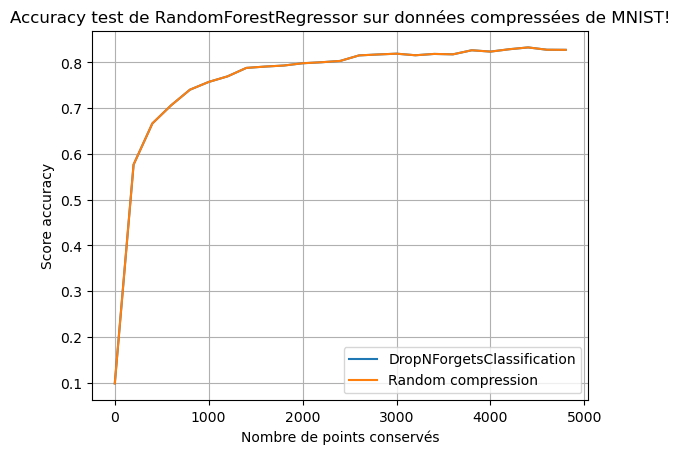

In [24]:
# baseline 
predictive_model = RandomForestClassifier(n_estimators=21, max_depth=7)
x, baseline = get_baseline(predictive_model, X_train, y_train, X_test, y_test, N_repeats=5, step=200)
display_forgetter_curve(x, baseline, x, baseline)


In [32]:

random_keeps = [0, 0.002, 0.01, 0.1, 0.05]
learning_rate = [0.1, 1, 2, 10]

# selectively compressed data

def get_score(X, y):
    predictive_model.fit(X, y)
    y_pred = predictive_model.predict(X_test)
    return accuracy_score(y_test, y_pred)

base_model = DecisionTreeClassifier(max_depth=2)
comp_model = ABClassifierForgetter(n_estimators=200, learning_rate=1)
comp_model.fit(X_train, y_train)

# n doesn't matter here as we later loop over all ns to generate graph
compression_strategy = DropNForgetsClassification(n=1)
_ = comp_model.transform(X_train, compression_strategy)
counts = compression_strategy.get_counts()

print(counts)

[3 2 7 ... 5 3 1]


[3, 2, 7, 5, 8, 2, 1, 5, 6, 1, 3, 0, 0, 1, 7, 1, 0, 1, 1, 0, 1, 4, 0, 1, 1, 5, 0, 0, 4, 0, 2, 2, 0, 7, 0, 3, 3, 3, 3, 1, 4, 0, 7, 0, 1, 0, 0, 2, 7, 1, 1, 0, 9, 1, 1, 3, 0, 1, 4, 5, 2, 5, 2, 1, 2, 5, 0, 2, 2, 4, 1, 3, 2, 0, 0, 0, 10, 4, 1, 2, 1, 2, 1, 2, 2, 1, 0, 0, 0, 4, 0, 1, 3, 4, 0, 1, 10, 7, 0, 0, 3, 0, 1, 2, 0, 0, 0, 0, 0, 3, 4, 2, 0, 1, 9, 0, 2, 3, 2, 0, 2, 0, 0, 0, 9, 1, 0, 0, 0, 2, 0, 3, 0, 9, 0, 0, 0, 0, 3, 0, 5, 1, 0, 5, 0, 0, 2, 1, 0, 0, 4, 3, 1, 2, 0, 0, 3, 1, 0, 3, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 1, 3, 2, 0, 0, 6, 3, 4, 3, 7, 0, 0, 0, 1, 3, 2, 1, 5, 0, 1, 5, 0, 3, 0, 3, 8, 0, 0, 0, 0, 0, 2, 1, 0, 3, 1, 4, 0, 0, 0, 0, 2, 6, 0, 0, 1, 4, 2, 6, 2, 3, 0, 2, 2, 8, 6, 2, 2, 0, 1, 0, 3, 3, 5, 3, 1, 3, 0, 4, 1, 0, 2, 3, 0, 3, 2, 9, 7, 0, 0, 1, 0, 5, 0, 2, 0, 3, 3, 7, 6, 0, 0, 0, 5, 3, 0, 1, 0, 3, 2, 0, 8, 1, 6, 3, 1, 4, 3, 9, 2, 0, 9, 4, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 4, 0, 3, 1, 1, 1, 13, 1, 0, 0, 0, 0, 0, 7, 4, 0, 0, 0, 5, 0, 0, 0, 4, 0, 1, 0, 4, 2, 2, 0, 1, 11, 5, 2, 4, 0,

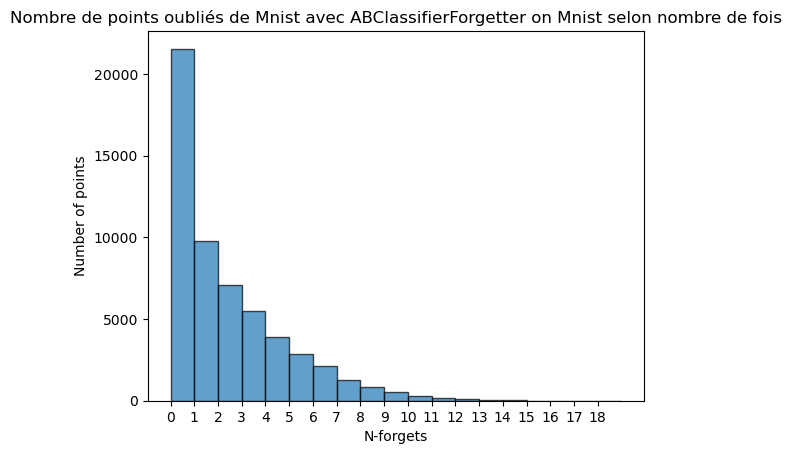

In [33]:
print(counts.tolist())

import numpy as np
import matplotlib.pyplot as plt

bins = np.arange(min(counts), max(counts) + 2)  # +2 to include the last integer

# Plot histogram with automatic bins
plt.hist(counts, bins=bins, edgecolor='black', alpha=0.7)
plt.xticks(np.arange(min(counts), max(counts) + 1))  # Ensures all integers are shown

# Labels and title
plt.xlabel("N-forgets")
plt.ylabel("Number of points")
plt.title("Nombre de points oubliés de Mnist avec ABClassifierForgetter on Mnist selon nombre de fois")

plt.show()

Performance for rk = 0 and lr = 1
[3 2 7 ... 5 3 1]
21554


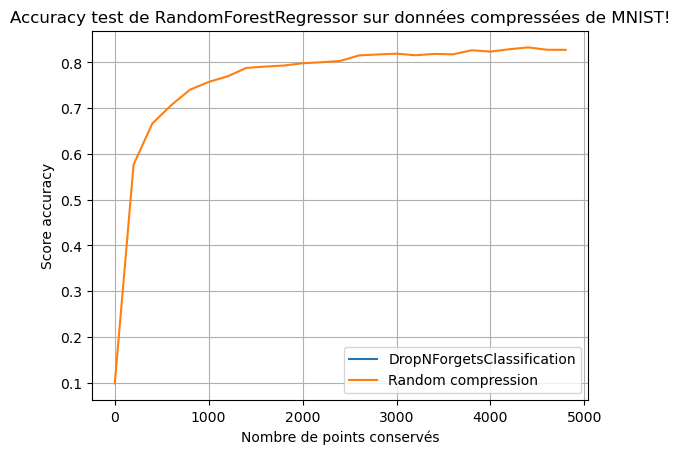

Performance for rk = 0.002 and lr = 1
[3 2 7 ... 5 3 1]
21519


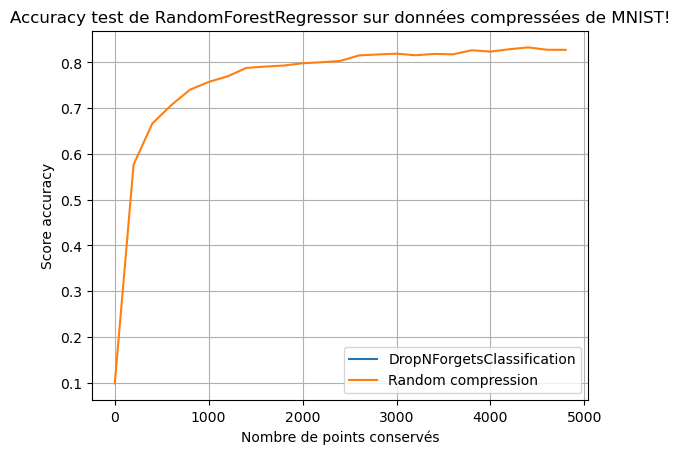

Performance for rk = 0.01 and lr = 1
[3 2 7 ... 5 3 1]
21349


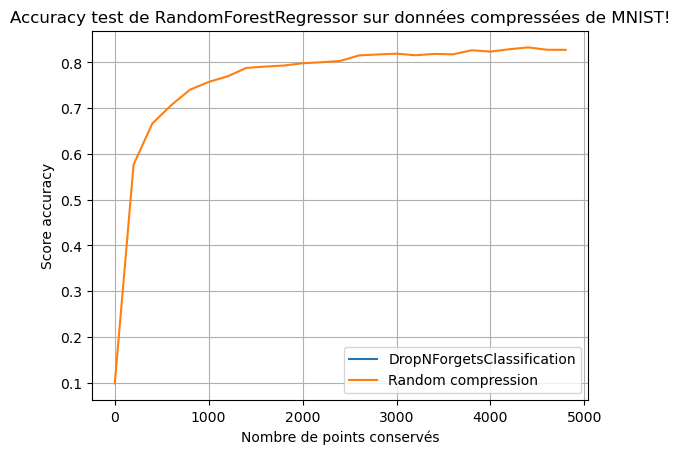

Performance for rk = 0.1 and lr = 1
[3 2 7 ... 5 3 1]
19404


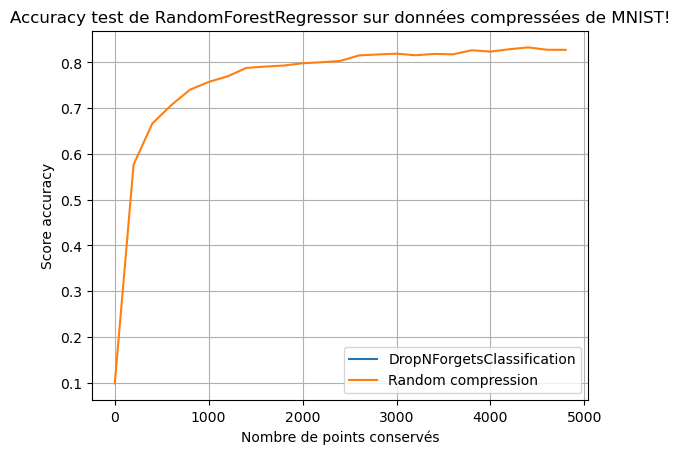

Performance for rk = 0.05 and lr = 1
[3 2 7 ... 5 3 1]
20493


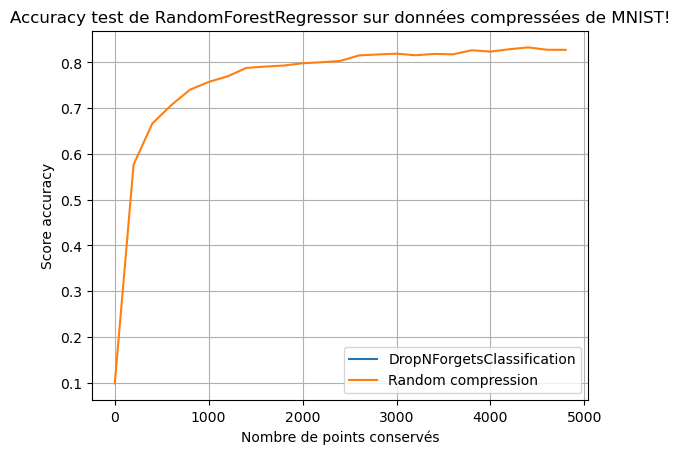

In [34]:
for rk in random_keeps:            
        print(f"Performance for rk = {rk} and lr = {1}")
                    
        x_c_score = []
        y_c_score = []
        
        print(counts)
        for nf in range(max(counts)):
        #for nf in range(max(counts) - 1, -1, -1):
            comp = DropNForgetsClassification(n=nf, random_keeps=rk)
            mask = ~comp.get_compression_mask(comp_model.predictions_over_time, y_train)
            X_comp = X_train[mask]
            y_comp = y_train[mask]
            print(len(y_comp))
            if(len(y_comp) > 5000): break
            
            x_c_score.append(len(y_comp))       
            y_c_score.append(get_score(X_comp, y_comp))
    
        display_forgetter_curve(x_c_score, y_c_score, x, baseline)
        
        #display_pca_and_labels(X_train,y_train, mask)
        #display_only_kept_points(X_train,y_train, mask)